# Portfolio-Exam Part I - Sentiment Analysis

* Social Media Analytics - MADS-SMA
* Valentin Werger

In [34]:
# Compare different approaches
# Train own word embedding
# Use model trained on yelp for other data
# Try out sentiments towards types of entities

In [1]:
# Loading required ML packages and functions
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
# Read Hamburg Yelp reviews
yelp = pd.read_csv("data/yelp_reviews_hamburg_en.csv", parse_dates=["date"])

In [4]:
# Overview of the data
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3025 entries, 0 to 3024
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   url     3025 non-null   object        
 1   stars   3025 non-null   float64       
 2   text    3025 non-null   object        
 3   date    3025 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 94.7+ KB


In [5]:
# Show the top 5 rows
yelp.head(5)

,url,stars,text,date
0,https://www.yelp.com/biz/il-buco-hamburg,5.0,Fantastic little restaurant!Great staff and fo...,2017-08-12
1,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,We went there to grab some breakfast. They are...,2015-09-29
2,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,"Good coffee, sandwiches, and yogurts close t...",2016-01-13
3,https://www.yelp.com/biz/campus-suite-hamburg-7,3.0,When XING handed out coupons for free coffee d...,2008-04-24
4,https://www.yelp.com/biz/campus-suite-hamburg-7,4.0,I love Campus Suite franchise. after the Balza...,2010-01-15


In [6]:
# Extract name of the location from url
yelp["name"] = yelp.apply(lambda row: re.sub("https://www.yelp.com/biz/", "", row["url"]), axis=1)
yelp = yelp.drop(columns="url")

<AxesSubplot:ylabel='Count'>

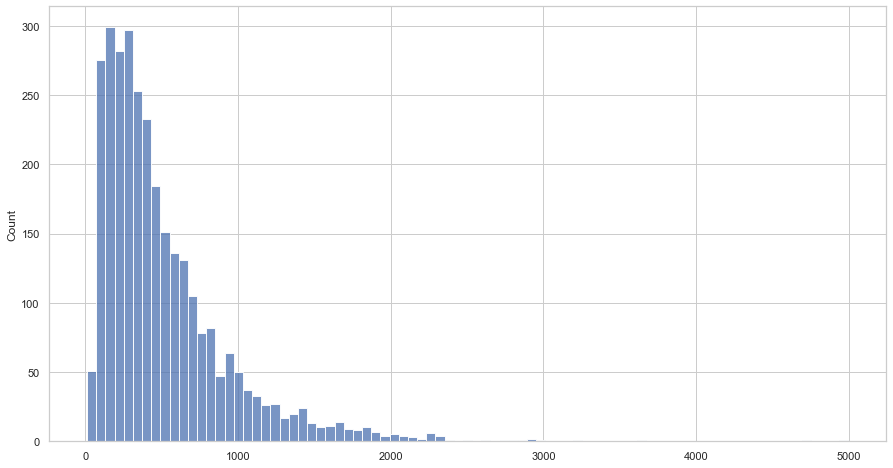

In [7]:
# Inspect length of review text
text_length_distribution = np.array([len(text) for text in yelp.text])

sns.set_theme(style="whitegrid")
plt.figure(figsize=[15,8])
sns.histplot(data = text_length_distribution)

# Problem: Maximum length of Bert is 512


In [ ]:
# Sentiment Analyser class
class SentimentAnalyser():

    def __init__(self, data, target, normalize = True):
        self.data = data
        self.target = target
        self.target_distribution = self.data[self.target].value_counts(normalize=True)

        if normalize:
            self.data["text"] = self.normalize()

    def __normalize_document(self, doc, tokenizer, stop_words):

        doc = re.sub(r'@[\w]+', '', doc)          # replace user mentions
        doc = re.sub(r'http[\S]+', 'URL', doc)    # replace URLs
        doc = re.sub(r'[^\w\s]', '', doc)         # keep words and spaces
        doc = doc.lower()
        doc = doc.strip()
        tokens = tokenizer.tokenize(doc)
        filtered_tokens = [token for token in tokens if token not in stop_words]
        doc = ' '.join(filtered_tokens)
        return doc

    def normalize(self):

        stop_words = nltk.corpus.stopwords.words('english')
        wpt = nltk.WordPunctTokenizer()

        return self.data.apply(lambda x: self.__normalize_document(x, wpt, stop_words))

    def naive_baseline(self):

        self.data["naive_baseline_prediction"] = np.random.choice(target_distribution.index.to_numpy(), size = len(yelp), replace = True, p = target_distribution.values)

    def vader_sentiment(self):

        vader = SentimentIntensityAnalyzer()
        self.data['vader_scores'] = self.data.text.apply(lambda x: vader.polarity_scores(x))
        self.data['vader_compound'] = self.data.vader_scores.apply(lambda x: x['compound'])
        self.data['vader_prediction'] = self.data.vader_compound.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.vader_polarity, normalize='all')

    def textblob_sentiment(self):

        self.data['textblob_score'] = self.data.text.apply(
            lambda review: TextBlob(review).sentiment[0])
        self.data['textblob_prediction'] = self.data.textblob_score.apply(lambda x: 1 if x >= 0 else 0)
        pd.crosstab(self.data[self.target], self.data.textblob_pred, normalize='all')

    def evaluate_classifier(self):

        # Setting up the pipeline
        pipeline = Pipeline([('wordcount', CountVectorizer()), ('tdif', TfidfTransformer()), ('scaler', StandardScaler()), ('oversampler', SMOTE()), ('estimator', model)])
    
    

In [ ]:
def evaluate_classifier(name, model, params, features, target, iterations, cv_splits, cv_repeats):

    # Setting up the pipeline
    pipeline = Pipeline([('scaler', StandardScaler()), ('oversampler', SMOTE()), ('estimator', model)])

    # Setting up the Cross validation
    inner_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)
    outer_cv = RepeatedStratifiedKFold(n_splits = cv_splits, n_repeats = cv_repeats, random_state = 33)

    # Doing hyperparameter optimization
    optimization = RandomizedSearchCV(
        estimator = pipeline,
        param_distributions = params,
        scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc'],
        cv = inner_cv,
        refit = 'roc_auc',
        n_iter = iterations,
        n_jobs = os.cpu_count() -1,
        verbose = 10,
        random_state = 33)

    optimization.fit(features, target)

    # Evaluating the best model on the outer cross validation
    performance_estimation = cross_validate(
        estimator = optimization,
        X = features,
        y = target,
        scoring = ['accuracy', 'balanced_accuracy', 'f1', 'roc_auc'],
        cv = outer_cv,
        n_jobs = os.cpu_count() -1)

    return(
        {
            'name': name,
            'optimization_cv_results': pd.DataFrame(optimization.cv_results_),
            'best_params': optimization.best_params_,
            'best_model': optimization.best_estimator_,
            'acc': performance_estimation['test_accuracy'],
            'balanced_acc': performance_estimation['test_balanced_accuracy'],
            'f1': performance_estimation['test_f1'],
            'roc_auc': performance_estimation['test_roc_auc']
        }
    )

In [ ]:
# Sentiment analysis on the document level

# 1. Rule based
    # Vader
    # Text Blob
# 2. ML based - Classification or Regression?
    # own feature engineering plus defined models
        # bag of words
        # TD-IF
        # word vectors
    # Transformers